# Evaluation of model Generalization

For evaluation models and corresponding datasets on different cell types, microscopes and models are used.  
Evaluation is done on a grid seach with models and data with the following structure:

**Models:**
* grid_search_models  
    * [model]_[microscope]_[evaluation cell type]
        * saved_model
    * [model]_[microscope]_[evaluation cell type]
        * saved_model
    * ...
    
*e.g. model name: ssd_brightfield_hela*

**Data:**
* my_data
    * [microscope]_[cell type].tfrecord
    
*e.g. data name: brightfield_hela.tfrecord*

In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from data.tf_record_loading import tf_dataset_generator
from prediction.prediction_utils import load_model, run_inference_for_single_image
from statistics import get_performance_metrics

In [2]:
# Set default figure size
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [7]:
# Set models path
models = Path(r"D:\Nabil_object_detection\models\graph_cell_type_cv_brightness")

# Set evaluation data path
data = Path(r"D:\Nabil_object_detection\data\experiments\cell_type\cross_validation")

In [8]:
def find_data_path(model_path, data_path):
    """    
    Finds evaluation data [microscopre, cell] path for a given model [type, microscope, cell].
    """

    model_type, microscope, cell_type = model_path.name.split("_")
    
    for record in data_path.iterdir():
        record_microscope, record_cell_type, *_ = record.stem.split("_")

        if len(_) > 0: continue # Continue if more then 1 "_" in record.name.       
        if (record_microscope == microscope) and (record_cell_type == cell_type):
            return record

    raise FileNotFoundError(f"No record found for model {model_path} in {data_path}")

# Get evaluation metrics

In [5]:
def measure_performance(detector, annot):
        gt_bboxes = annot.get("bboxes")
        prediction = run_inference_for_single_image(model, annot.get("image"))
        prediction = prediction.get("detection_boxes")
        return get_performance_metrics(prediction, gt_bboxes, iou=0.5)
    
def update_metrics(m, n):
    for key, value in n.items():
        m[key].append(value)
    return m

In [6]:
metrics = {
    "model_type": [],
    "microscope": [],
    "eval_cell_type": [],
    "map": [],
    "fscore": [],
    "image_path": [],
    "model_path": []
}

In [12]:
for model_path in models.iterdir():
    
    # Extract experiment meta
    model_type, microscope, cell_type = model_path.name.split("_")

    # Load model and data
    eval_data = tf_dataset_generator(find_data_path(model_path, data))
    model = load_model(model_path)
    
    for query in eval_data:
        
        image_path = Path(query.get("name").decode("utf-8"))
        print(f"Evaluating {model_path.name}\tImage: {image_path.name}", end="\r")
        
        performance = measure_performance(model, query)

        update_metrics(metrics, {"model_type": model_type,
                                 "microscope": microscope,
                                 "eval_cell_type": cell_type,
                                 "map": performance["map"],
                                "fscore": performance["fscore"],
                                "image_path": image_path,
                                "model_path": model_path})
    print(f"\tFinished {model_path.name}")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_brightfield_3t33	Image: Stack0077.png
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_brightfield_a5499	Image: brightfield0069.png
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_brightfield_helaa	Image: brightfield0206.png
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_brightfield_nrkk	Image: Stack0074.png
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_lensfree_3t33	Image: z00077.pngg
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_lensfree_a5499	Image: lensfree0069.png
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
	Finished ssd_lensfree_helaa	Image: lensfree0206.png
IN

In [13]:
metric_df = pd.DataFrame(metrics)

In [14]:
metric_df

,model_type,microscope,eval_cell_type,map,fscore,image_path,model_path
0,ssd,brightfield,3t3,0.369979,0.200000,D:\Nabil_object_detection\data\annotations\3t3...,D:\Nabil_object_detection\models\graph_cell_ty...
1,ssd,brightfield,3t3,0.869259,0.299411,D:\Nabil_object_detection\data\annotations\3t3...,D:\Nabil_object_detection\models\graph_cell_ty...
2,ssd,brightfield,3t3,0.884555,0.296610,D:\Nabil_object_detection\data\annotations\3t3...,D:\Nabil_object_detection\models\graph_cell_ty...
3,ssd,brightfield,3t3,0.768765,0.282333,D:\Nabil_object_detection\data\annotations\3t3...,D:\Nabil_object_detection\models\graph_cell_ty...
4,ssd,brightfield,3t3,0.513288,0.227119,D:\Nabil_object_detection\data\annotations\3t3...,D:\Nabil_object_detection\models\graph_cell_ty...
...,...,...,...,...,...,...,...
1327,ssd,lensfree,nrk,0.705082,0.501416,D:\Nabil_object_detection\data\annotations\nrk...,D:\Nabil_object_detection\models\graph_cell_ty...
1328,ssd,lensfree,nrk,0.730249,0.521374,D:\Nabil_object_detection\data\annotations\nrk...,D:\Nabil_object_detection\models\graph_cell_ty...
1329,ssd,lensfree,nrk,0.728998,0.520644,D:\Nabil_object_detection\data\annotations\nrk...,D:\Nabil_object_detection\models\graph_cell_ty...
1330,ssd,lensfree,nrk,0.715001,0.508403,D:\Nabil_object_detection\data\annotations\nrk...,D:\Nabil_object_detection\models\graph_cell_ty...


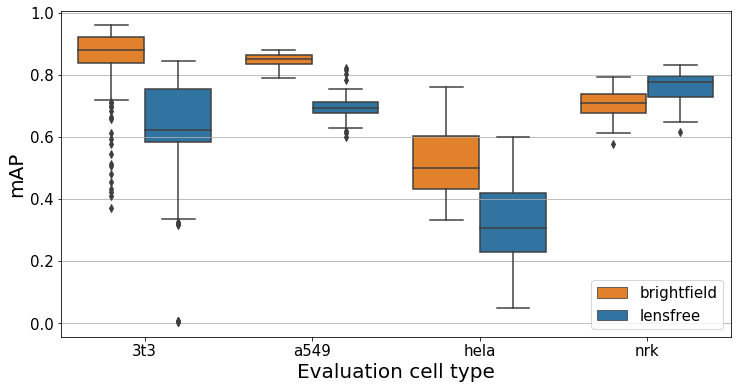

In [15]:
sns.boxplot(x="eval_cell_type", y="map", hue="microscope", data=metric_df,  palette=['#ff7f0e', '#1f77b4'])
plt.xlabel("Evaluation cell type", fontsize=20)
plt.ylabel("mAP", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="y")